In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
plt.rcParams.update({'font.size': 13.4})
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ettouilebouael/churn_prediction/main/churn.csv', sep=',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.TotalCharges = df.TotalCharges.replace(" ", np.NaN)
df.TotalCharges = pd.to_numeric(df.TotalCharges)
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [4]:
df.Churn = df.Churn.replace({"No" : 0 , "Yes" : 1})

In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [6]:
cat_col = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

num_col = ['tenure', 'MonthlyCharges', 'TotalCharges']




In [7]:
for i in cat_col :
  print(" ")
  print(i)
  print(df[i].value_counts())

 
gender
Male      3555
Female    3488
Name: gender, dtype: int64
 
SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
 
Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
 
Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
 
PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
 
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
 
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
 
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
 
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
 
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
 
TechSupport
N

In [8]:
df_cat = pd.get_dummies(df[cat_col], drop_first = True)
df = pd.concat((df[num_col], df_cat, df.Churn), axis = 1)
df.dropna(inplace = True)
X = df.iloc[:,:-1].values
y = df.Churn.values


## Feature Selection

### Test de khi deux

In [9]:
from sklearn.feature_selection import chi2
pvalues = pd.DataFrame(np.transpose(chi2(df[df_cat.columns], df.Churn)), columns = ["khi2", "p-value"])
pvalues["columns"] = df_cat.columns
pvalues["p-value"] = pvalues["p-value"].round(2)
print(pvalues.to_latex(index = False))


\begin{tabular}{rrl}
\toprule
       khi2 &  p-value &                                columns \\
\midrule
 133.482766 &     0.00 &                          SeniorCitizen \\
   0.254297 &     0.61 &                            gender\_Male \\
  81.857769 &     0.00 &                            Partner\_Yes \\
 131.271509 &     0.00 &                         Dependents\_Yes \\
   0.092948 &     0.76 &                       PhoneService\_Yes \\
   0.868247 &     0.35 &         MultipleLines\_No phone service \\
   6.514651 &     0.01 &                      MultipleLines\_Yes \\
 372.082851 &     0.00 &            InternetService\_Fiber optic \\
 285.475152 &     0.00 &                     InternetService\_No \\
 285.475152 &     0.00 &     OnlineSecurity\_No internet service \\
 147.165601 &     0.00 &                     OnlineSecurity\_Yes \\
 285.475152 &     0.00 &       OnlineBackup\_No internet service \\
  31.209832 &     0.00 &                       OnlineBackup\_Yes \\
 285.475152

In [10]:
filtred_features = ["PhoneService_Yes", "MultipleLines_No phone service", "gender_Male"]

### Test de Anova

In [20]:
num_col = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_col].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.246862,0.825880
MonthlyCharges,0.246862,1.000000,0.651065
TotalCharges,0.825880,0.651065,1.000000


In [24]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
pvalues = pd.DataFrame(np.transpose(chi2(df[num_col], df.Churn)), columns = ["F-statistic", "p-value"])

pvalues["columns"] = df[num_col].columns
pvalues["p-value"] = pvalues["p-value"].round(2)
print(pvalues.to_latex(index = False))

\begin{tabular}{rrl}
\toprule
   F-statistic &  p-value &         columns \\
\midrule
  16377.328093 &      0.0 &          tenure \\
   3653.074681 &      0.0 &  MonthlyCharges \\
 629630.810349 &      0.0 &    TotalCharges \\
\bottomrule
\end{tabular}



### Logistic Regression with L1 Penality

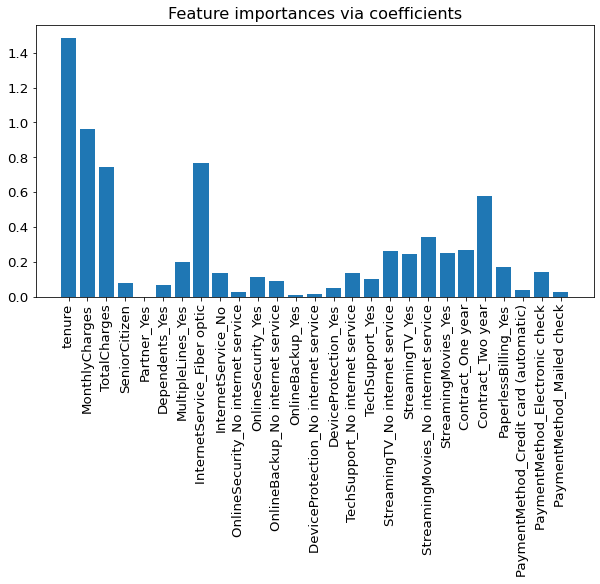

In [94]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline

X = df.iloc[:,:-1]
X = X.drop(filtred_features, axis = 1)
feature_names = X.columns
X = X.values
y = df.Churn.values

kf = StratifiedKFold(5)
plt.figure(figsize = (10,5))
scaler = StandardScaler()
X = scaler.fit_transform(X)
lasso = LogisticRegressionCV(max_iter = 500, scoring = "roc_auc", penalty = "l1", solver = "liblinear", cv = kf).fit(X, y)
importance = np.abs(lasso.coef_.reshape(-1))
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation = 90)
plt.show()

In [118]:
a = SelectFromModel(lasso, threshold=0.2, prefit = True)
co = a.get_support()

In [115]:
co.shape

(27,)

In [120]:
feature_names[co]

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year'],
      dtype='object')